## Import Libraries ##

In [261]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import itertools
import skimage as sk
import cv2

from sklearn.model_selection import train_test_split
%matplotlib inline
from skimage.transform import resize


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [262]:
torch.cuda.is_available()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

## Read in image ##

(512, 512, 3)
(512, 512, 3)


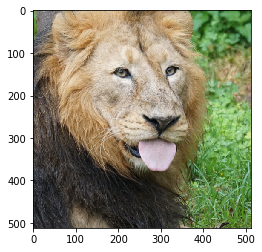

In [118]:
im = plt.imread("input/lion_orig.png")
im = sk.img_as_float(im)
print(im.shape)
im = resize(im, (im.shape[0] , im.shape[1]), anti_aliasing=True)
print(im.shape)
plt.imshow(im)

## Positional Encoding Implementation ##

In [119]:
def pos_enc(p, L): 
    if L <= 0:
        return p
    v_proj = (np.pi * p)
    out_enc = np.concatenate([np.sin(v_proj), np.cos(v_proj)], axis=-1)
    for l in np.arange(1, L):
        v_proj = (pow(2.0, l) * np.pi * p)
        out_enc = np.concatenate([out_enc, np.sin(v_proj), np.cos(v_proj)], axis=-1)
    return out_enc

## Setting up Training and Test Data ##

In [120]:
L = 8
coords = np.linspace(0, 1, im.shape[0], endpoint=False)
x_test = np.stack(np.meshgrid(coords, coords), -1)
X_train = torch.from_numpy(pos_enc(x_test[::2,::2], L))
y_train = torch.from_numpy(im[::2,::2])
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = torch.from_numpy(pos_enc(x_test, L))
X_test = X_test.to(device)
y_test = torch.from_numpy(im).to(device)

"Test shape: ", X_test.shape, y_test.shape, "Train shape: ", X_train.shape, y_train.shape
# we need to apply the positional encodings for higher frequency output

('Test shape: ',
 torch.Size([512, 512, 32]),
 torch.Size([512, 512, 3]),
 'Train shape: ',
 torch.Size([256, 256, 32]),
 torch.Size([256, 256, 3]))

## Model Specification ##

In [121]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(max(2, 4*L), 256), # add 6 layers
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [122]:
model = MLP()
model = model.to(device)
#print(model)
X_train.is_cuda, y_train.is_cuda

(True, True)

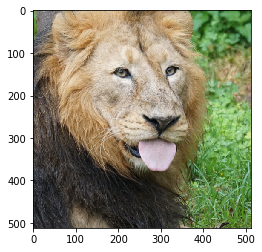

In [123]:
plt.imshow(y_test.cpu().detach().numpy())

In [124]:
X_train.shape

torch.Size([256, 256, 32])

**Train Model**

In [125]:
l_r = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=l_r)
loss_fn = nn.MSELoss()
epochs = 2000
visual = False

for epoch in range(epochs):
    optimizer.zero_grad()
    model.train()
    X_train.to(device)
    outputs = model(X_train.float())
    loss = loss_fn(outputs, y_train)
    if epoch % 100 == 0:
        print(epoch, loss.item())
    loss.backward()
    optimizer.step()
    
    if visual and epoch % 100 == 0:
        plt.imshow(outputs.cpu().detach().numpy())
        plt.show()
            
    model.eval()

0 0.055655401200056076
100 0.02262810617685318
200 0.011425246484577656
300 0.008350659161806107
400 0.00686732679605484
500 0.006017882376909256
600 0.005306973587721586
700 0.004826040472835302
800 0.004428102634847164
900 0.004111323039978743
1000 0.003855657996609807
1100 0.0037286195438355207
1200 0.0034770325291901827
1300 0.0033204175997525454
1400 0.0031926699448376894
1500 0.0030758811626583338
1600 0.0029718552250415087
1700 0.0028878329321742058
1800 0.0027946075424551964
1900 0.003017551265656948


## Visualize Results ##

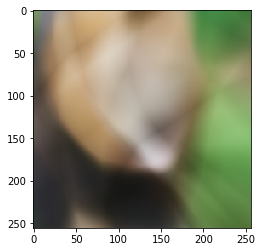

In [79]:
# WITH positional encoding (L = 0, epochs = 2000)
plt.imshow(outputs.cpu().detach().numpy())

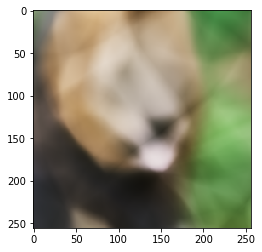

In [86]:
# WITH positional encoding (L = 1, epochs = 2000)
plt.imshow(outputs.cpu().detach().numpy())

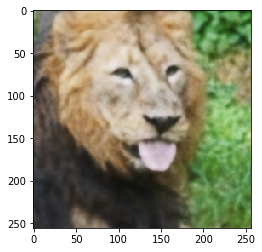

In [94]:
# WITH positional encoding (L = 5, epochs = 2000)
plt.imshow(outputs.cpu().detach().numpy())

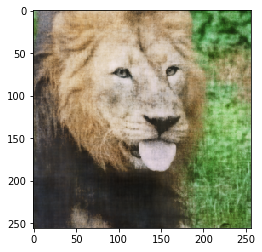

In [126]:
# WITH positional encoding (L = 8, epochs = 2000) with deeper model
plt.imshow(outputs.cpu().detach().numpy())

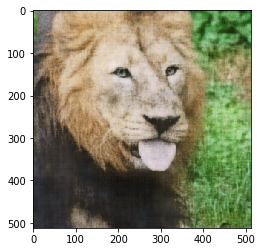

In [127]:
final = model(X_test.float())
plt.imshow(final.cpu().detach().numpy())

## Masked Images ##

In [308]:
def trainModel(img, L=8, lr=1e-4, epochs=2000, visual=False, verbal=True, model_class=MLP):
    coords = np.linspace(0, 1, img.shape[0], endpoint=False)
    x_test = np.stack(np.meshgrid(coords, coords), -1)
    X_train = torch.from_numpy(pos_enc(x_test[::,::], L))
    y_train = torch.from_numpy(img[::,::])
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    X_test = torch.from_numpy(pos_enc(x_test, L))
    X_test = X_test.to(device)
    y_test = torch.from_numpy(img).to(device)
    
    model = model_class()
    model = model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        model.train()
        X_train.to(device)
        outputs = model(X_train.float())
        loss = loss_fn(outputs, y_train.float())
        if verbal and epoch % 100 == 0:
            print(epoch, loss.item())
        loss.backward()
        optimizer.step()

        if visual and epoch % 100 == 0:
            plt.imshow(outputs.cpu().detach().numpy())
            plt.show()

        model.eval()
    return model, outputs.cpu().detach().numpy()

(256, 256, 3)


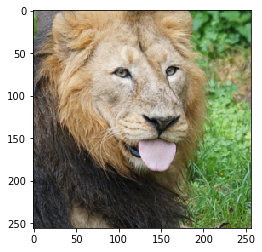

In [198]:
im = plt.imread("input/lion_orig.png")
im = sk.img_as_float(im)
im = resize(im, (im.shape[0] // 2, im.shape[1] // 2), anti_aliasing=True)
print(im.shape)
plt.imshow(im)

(256, 256, 3)


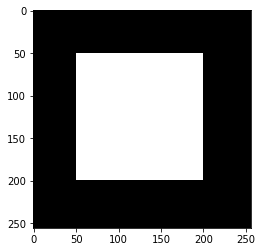

In [199]:
masked = np.zeros(im.shape, float)
x, y = 50, 50
h, w = 150, 150
#masked[y:y+h,x:x+w] = im[y:y+h,x:x+w]
masked[y:y+h,x:x+w, :] = np.ones((h, w, 3))
masked = resize(masked, (im.shape[0], im.shape[1]), anti_aliasing=True)
print(masked.shape)
plt.imshow(masked)

In [200]:
L = 8
masked_img = np.multiply(masked, im)
masked_model, masked_output = trainModel(masked_img, L)

0 0.1785539835691452
100 0.061788152903318405
200 0.014808048494160175
300 0.005044638644903898
400 0.003333702450618148
500 0.002270785393193364
600 0.0016852096887305379
700 0.001335078733973205
800 0.0011176824336871505
900 0.0009540614555589855
1000 0.0008354946039617062
1100 0.000760803057346493
1200 0.0006740574608556926
1300 0.0006047298084013164
1400 0.0005494653014466166
1500 0.0005073664360679686
1600 0.00046803653822280467
1700 0.0004350841336417943
1800 0.0004162002878729254
1900 0.00039217877201735973


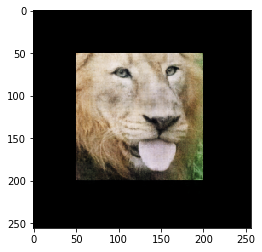

In [201]:
plt.imshow(masked_output)
# try without black border, dont upscale, train, crop and calc psnr against crops

In [192]:
L = 8
flipped = np.ones(masked.shape) - masked
maskflip_img = np.multiply(flipped, im)
maskflip_model, maskflip_output = trainModel(maskflip_img, L)

0 0.12333711981773376
100 0.04708786681294441
200 0.014617301523685455
300 0.005387160927057266
400 0.003952073398977518
500 0.0031566161196678877
600 0.00260259211063385
700 0.0022354330867528915
800 0.001951393554918468
900 0.0017453936161473393
1000 0.0015911165392026305
1100 0.001449447008781135
1200 0.0013372200774028897
1300 0.0012472799280658364
1400 0.0011719466419890523
1500 0.0011071937624365091
1600 0.0010495606111362576
1700 0.0010042203357443213
1800 0.0009568512323312461
1900 0.0009201795910485089


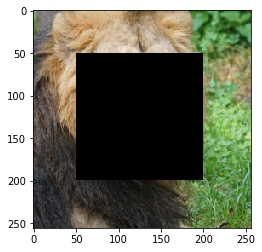

In [187]:
plt.imshow(maskflip_img)

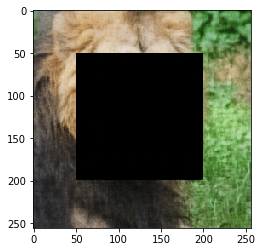

In [193]:
plt.imshow(maskflip_output)

In [149]:
L = 8
unmasked_model, unmasked_output = trainModel(im, L)

0 0.1386927217245102
100 0.0026564288418740034
200 0.0017867033602669835
300 0.0015551882097497582
400 0.001448125927709043
500 0.0013821739703416824
600 0.0013355185510590672
700 0.00129952363204211
800 0.0012779897078871727
900 0.0012443739688023925
1000 0.0012227536644786596
1100 0.0012032840168103576
1200 0.0013482013018801808
1300 0.0011715872678905725
1400 0.0013180505484342575
1500 0.001136667444370687
1600 0.0011724908836185932
1700 0.0011278585297986865
1800 0.0011581158032640815
1900 0.0010871635749936104


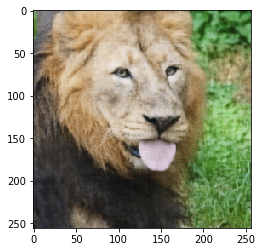

In [150]:
plt.imshow(unmasked_output)

## Basic Run ##

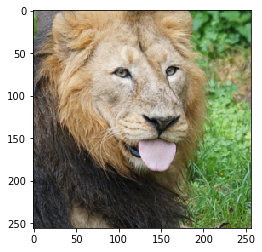

In [210]:
plt.imshow(im)

In [211]:
L = 8
sample_model, sample_output = trainModel(im, L)

0 0.054800719022750854
100 0.022462455555796623
200 0.009855262003839016
300 0.006972809787839651
400 0.005519253667443991
500 0.0046518766321241856
600 0.004037274047732353
700 0.0035757299046963453
800 0.00318983499892056
900 0.002887321636080742
1000 0.002664923435077071
1100 0.002482576062902808
1200 0.0023327076341956854
1300 0.002212090650573373
1400 0.0020975819788873196
1500 0.0019966529216617346
1600 0.0019355841213837266
1700 0.0018980327295139432
1800 0.00177369499579072
1900 0.001711052842438221


In [212]:
np.max(sample_output), np.max(im)

(0.9250824, 0.95342815)

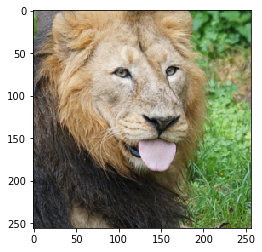

In [214]:
plt.imshow(im)

In [218]:
# try without black border, dont upscale, train, crop and calc psnr against crops
def psnr(predicted, original):
    mse = np.mean(np.square(predicted - original))
    return 10*np.log10(1./mse)

In [217]:
compare = cv2.PSNR(sample_output, im, R=1)
compare, psnr(sample_output, im)
# PSNR works

(27.56493584616543, 27.564936140500883)

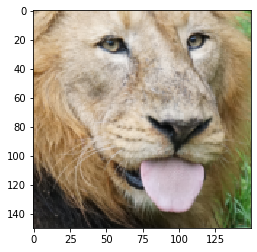

In [219]:
# area to crop
x, y = 50, 50
h, w = 150, 150
cropped = im[y:y+h,x:x+w, :]
plt.imshow(cropped)

In [220]:
L = 8
crop_model, crop_output = trainModel(cropped, L)

0 0.05431056022644043
100 0.023972032591700554
200 0.010006940923631191
300 0.005932234227657318
400 0.004167461302131414
500 0.0033693211153149605
600 0.0028102474752813578
700 0.002410466782748699
800 0.0020995531231164932
900 0.0018683235393837094
1000 0.0016859608003869653
1100 0.0015644363593310118
1200 0.0014142647851258516
1300 0.0013395205605775118
1400 0.0012190996203571558
1500 0.0012111512478441
1600 0.001081569236703217
1700 0.0010840981267392635
1800 0.0009609364788047969
1900 0.0009318525553680956


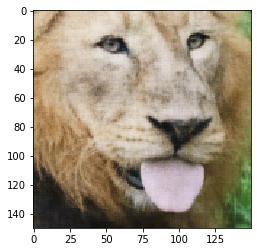

In [221]:
plt.imshow(crop_output)

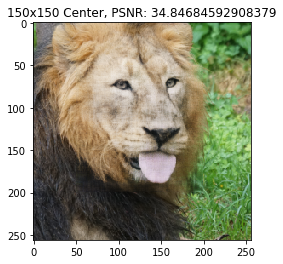

In [225]:
combined = im.copy()
combined[y:y+h,x:x+w, :] = crop_output
plt.imshow(combined)
plt.title("150x150 Center, PSNR: " + str(psnr(combined, im)))
plt.show()

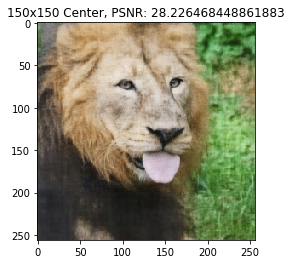

In [231]:
pred_combined = sample_output.copy()
pred_combined[y:y+h,x:x+w, :] = crop_output
plt.imshow(pred_combined)
plt.title("150x150 Center, PSNR: " + str(psnr(pred_combined, im)))
plt.show()

In [233]:
# cropped predicted with orig, full img predicted with orig, 
# real image border + predicted center with full orig, full img predicted border + separate predicted center with full orig
psnr(crop_output, cropped), psnr(sample_output, im), \
psnr(combined, im), psnr(pred_combined, im)

(30.203872448253545, 27.564936140500883, 34.84684592908379, 28.226468448861883)

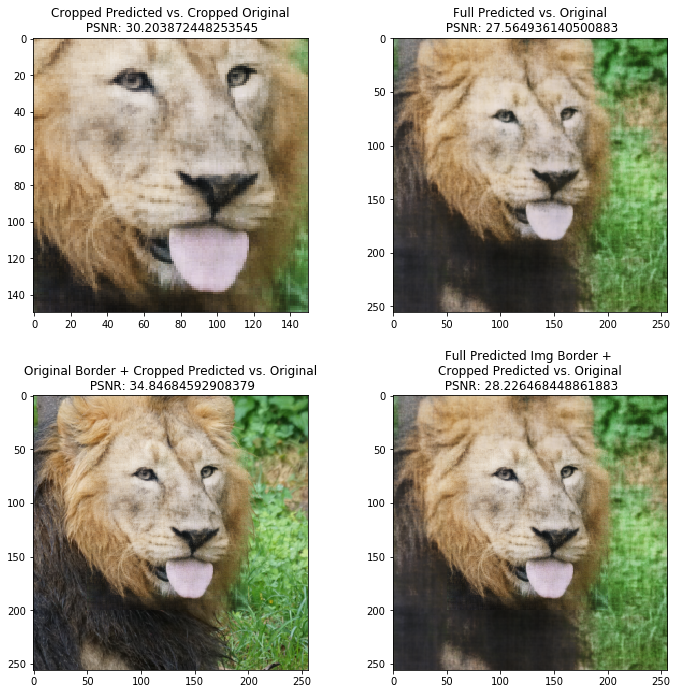

In [260]:
titles = ["Cropped Predicted vs. Cropped Original", "Full Predicted vs. Original", "Original Border + Cropped Predicted vs. Original",
          "Full Predicted Img Border + \nCropped Predicted vs. Original"]
predicted = [crop_output, sample_output, combined, pred_combined]
truth = [cropped, im, im, im]
fig = plt.figure()
fig.set_size_inches(10,10)

for i in np.arange(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(predicted[i])
    plt.title(titles[i] + "\n PSNR: " + str(psnr(predicted[i], truth[i])))

fig.tight_layout(pad=2)
plt.show()

## Varying the Size of the Center ##

In [318]:
def varyCenter(im, model_class = MLP):
    psnrs = []
    for percent in np.arange(0.1, 1.1, 0.1):
        h, w = int(percent * im.shape[0]), int(percent * im.shape[1])
        if percent >= 1.0:
            y, x = 0, 0
        else:
            y, x = (im.shape[0] - h)//2, (im.shape[1] - w)//2
        cropped = im[y:y+h,x:x+w, :]
        L = 8
        crop_model, crop_output = trainModel(cropped, L, verbal=False, model_class=model_class)
        
        pred_combined = sample_output.copy()
        pred_combined[y:y+h,x:x+w, :] = crop_output
        psnrs.append(psnr(pred_combined, im))
    
    # plot line graph of psnrs
    
    plt.plot(np.arange(0.1, 1.1, 0.1), psnrs)
    plt.title("% of Full Image as Center Predicted vs. PSNR")
    plt.xlabel("% of Full Image as Center")
    plt.ylabel("PSNR")
    plt.show()
    return psnrs

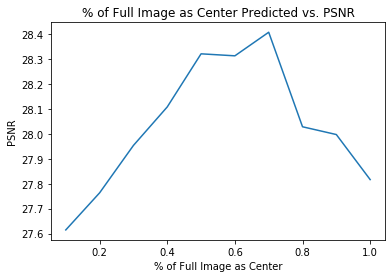

Trial 0 Done!


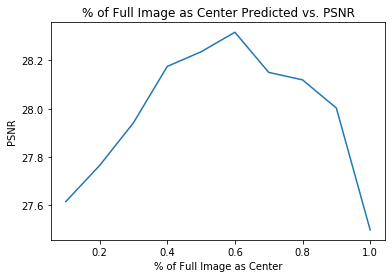

Trial 1 Done!


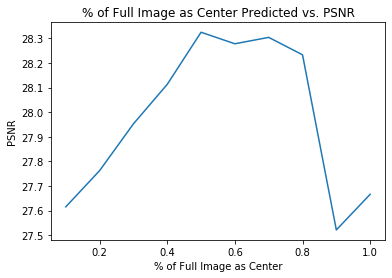

Trial 2 Done!


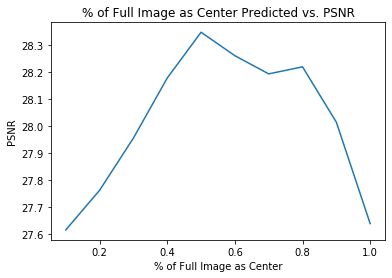

Trial 3 Done!


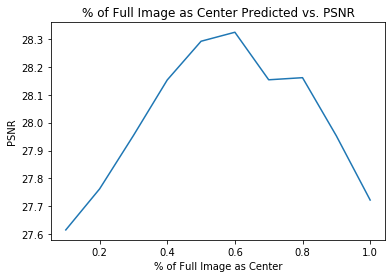

Trial 4 Done!


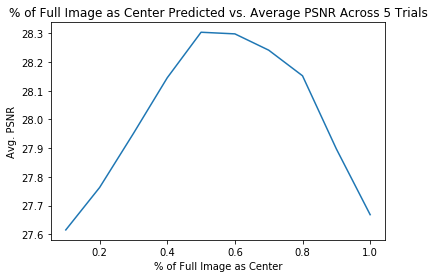

In [280]:
N = 5 # number of trials
trials = []
for i in range(N):
    trials.append(varyCenter(im)) # PSNR calculated between Separately predicted center + border of full predicted image vs original
    print("Trial " + str(i) + " Done!")

plt.plot(np.arange(0.1, 1.1, 0.1), np.mean(np.array(trials), axis=0))
plt.title("% of Full Image as Center Predicted vs. Average PSNR Across " + str(N) + " Trials")
plt.xlabel("% of Full Image as Center")
plt.ylabel("Avg. PSNR")
plt.show()

## Adding an alpha channel ##

In [288]:
# Adding an alpha channel
ima = np.ones((im.shape[0], im.shape[1], 4))
ima[:, :, :3] = im.copy()
ima[:, :, 3] = np.ones((im.shape[0], im.shape[1]))

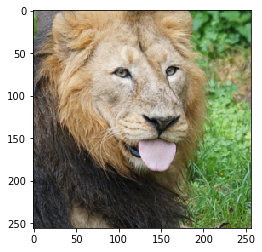

In [289]:
plt.imshow(ima)

In [304]:
class MLP_alpha(nn.Module):
    def __init__(self):
        super(MLP_alpha, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(max(2, 4*L), 256), # add 6 layers
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

0 0.10222423821687698
100 0.03522291034460068
200 0.014700189232826233
300 0.008358461782336235
400 0.005842206068336964
500 0.004565156530588865
600 0.003856030758470297
700 0.0034101945348083973
800 0.0030727835837751627
900 0.0027952115051448345
1000 0.002565263072028756
1100 0.0023713374976068735
1200 0.002220605034381151
1300 0.002184893935918808
1400 0.0019606868736445904
1500 0.0020018182694911957
1600 0.0018019006820395589
1700 0.0017114405054599047
1800 0.0016479376936331391
1900 0.0015918452991172671


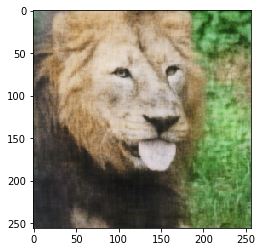

In [310]:
L = 8
alpha_model, alpha_output = trainModel(ima, L=L, model_class = MLP_alpha)
plt.imshow(alpha_output)
print(psnr(alph))

In [317]:
psnr(alpha_output, ima)

28.085230670548192

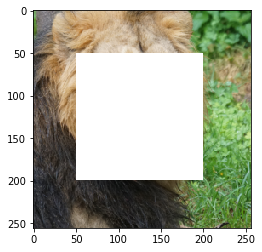

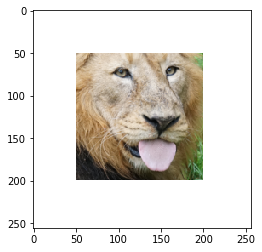

In [321]:
# if i keep the rgb values the same in the center and just change the alpha, that still won't be independent
x, y = 50, 50
h, w = 150, 150
ima_border, ima_center = ima.copy(), ima.copy()
ima_border[y:y+h,x:x+w, 3] = 0
ima_center[:, :, 3] = np.zeros((ima.shape[0], ima.shape[1]))
ima_center[y:y+h,x:x+w, 3] = 1

plt.imshow(ima_border)
plt.show()
plt.imshow(ima_center)
plt.show()